In [92]:
import os
import numpy as np
import pandas as pd
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [40]:
def rolling_window(array, window=1000):
    """
    apply a rolling window to a np.ndarray

    :param array: (np.ndarray) the input Array
    :param window: (int) length of the rolling window
    :return: (np.ndarray) rolling window on the input array
    """
    shape = array.shape[:-1] + (array.shape[-1] - window + 1, window)
    strides = array.strides + (array.strides[-1],)
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

In [72]:
def plot_one_line(y_mean, y_std=None, color=None, label=None):
    y_mean = y_mean[np.isfinite(y_mean)]
    y_mean_ = np.array([np.mean(y_mean[i:i+100]) for i in range(len(y_mean)-100)])
#     print(len(y_mean_))
    y_std_ = np.array([np.std(y_mean[i:i+100]) for i in range(len(y_mean)-100)])
#     print(len(y_std_))
    x = np.arange(len(y_mean_)) * 100
#     print(len(x))
    if y_std_ is not None:
        min_ = y_mean_ - y_std_
        max_ = y_mean_ + y_std_
        plt.fill_between(x, min_, max_, alpha=0.2, color=color)
    plt.plot(x, y_mean_, label=label, color=color)

In [97]:
from stable_baselines.results_plotter import COLORS

def plot(*paths):
    for path, color in zip(paths, COLORS):
        csv = pd.read_csv(os.path.join(path, 'progress.csv'))
#         pdf_path = os.path.join(path, 'ep_reward.pdf')
#         png_path = os.path.join(path, 'ep_reward.png')
        plot_one_line(csv['ep_reward_mean'], color=color)
        print('plotting', os.path.join(path, 'progress.csv'))
    
    plt.title('Mean Episode Reward')
    plt.xlabel('Episodes')
    # plt.legend()
    plt.grid()
#     pdf.savefig()
    plt.savefig(os.path.join(paths[0], 'reward.png'))
    plt.show()
#     plt.cla()

<IPython.core.display.Javascript object>


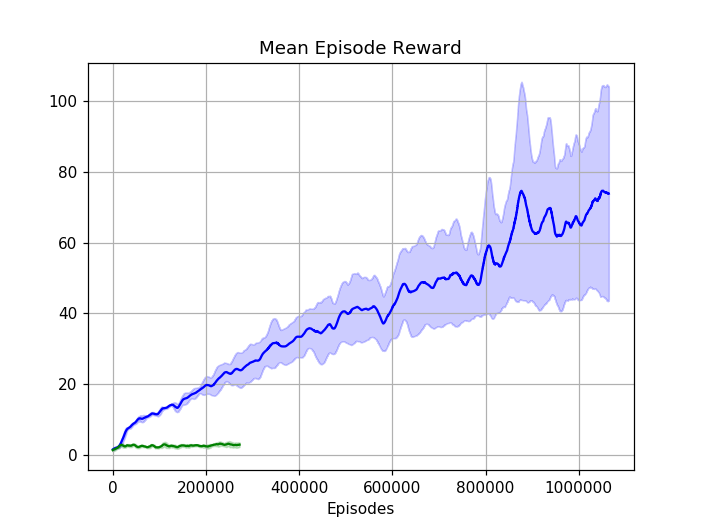

plotting logs/BreakoutNoFrameskip-v4/0/progress.csv
plotting logs/BreakoutNoFrameskip-v4/1/progress.csv


In [98]:
plot('logs/BreakoutNoFrameskip-v4/0/', 'logs/BreakoutNoFrameskip-v4/1/')